In [5]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report



In [6]:
load_dotenv()


# Подключение к БД
DATABASE_URL = os.getenv("DATABASE_URL")
engine = create_engine(DATABASE_URL)
query = "SELECT * FROM clear_dash_new"
df = pd.read_sql(query, engine)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Acc_date      285 non-null    object 
 1   Customer      285 non-null    object 
 2   Department    285 non-null    object 
 3   Sum           282 non-null    float64
 4   Payment_date  270 non-null    object 
 5   Exec_date     262 non-null    object 
 6   Responsible   285 non-null    object 
 7   Payment_time  270 non-null    float64
 8   Exec_time     262 non-null    float64
 9   month         285 non-null    object 
dtypes: float64(3), object(7)
memory usage: 22.4+ KB


In [7]:
df = df[['Customer', 'Department', 'Sum', 'Responsible', 'Payment_time']]

In [8]:
df['Payment_time'] = df['Payment_time'].fillna(df['Payment_time'].mean()).round().astype(int)

In [9]:
df.describe()

,Sum,Payment_time
count,2.820000e+02,285.000000
mean,2.053736e+05,9.396491
std,5.470738e+05,14.128210
min,2.500000e+03,-13.000000
25%,1.358250e+04,1.000000
50%,4.034408e+04,4.000000
75%,1.338275e+05,10.000000
max,6.100968e+06,75.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Customer      285 non-null    object 
 1   Department    285 non-null    object 
 2   Sum           282 non-null    float64
 3   Responsible   285 non-null    object 
 4   Payment_time  285 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 11.3+ KB


In [11]:
df.dropna(inplace=True)

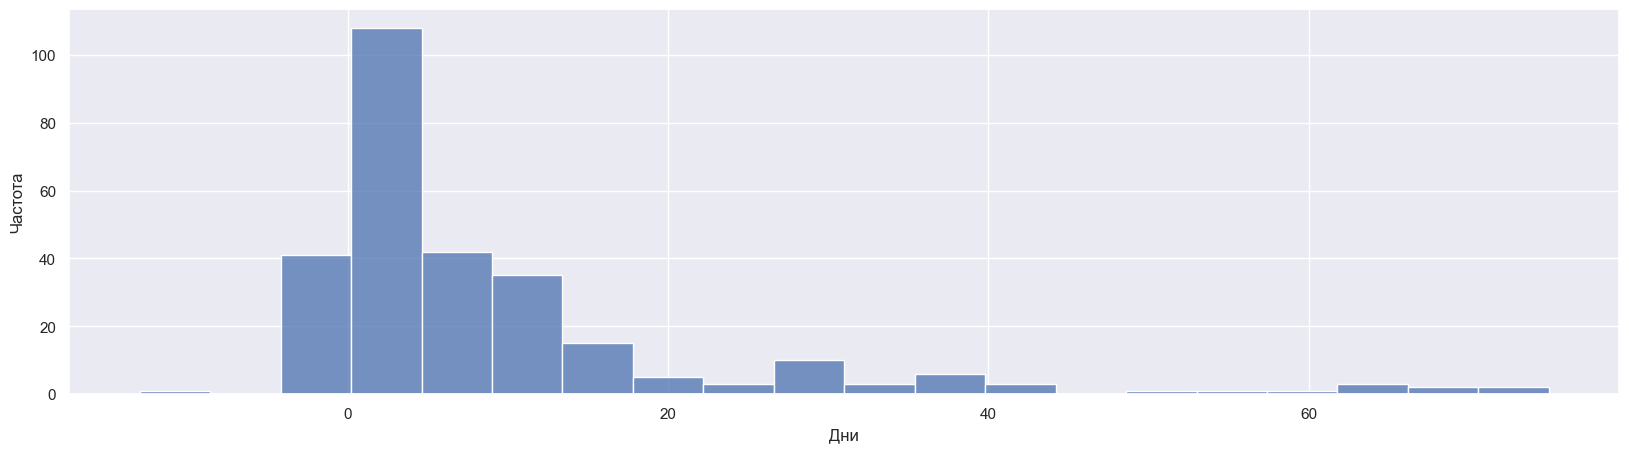

In [12]:
sns.set_theme(rc={'figure.figsize': (20,5)}) # смотрим распределение целевой переменной
sns.histplot(df['Payment_time'], bins=20)
plt.xlabel('Дни')
plt.ylabel('Частота')
plt.show()

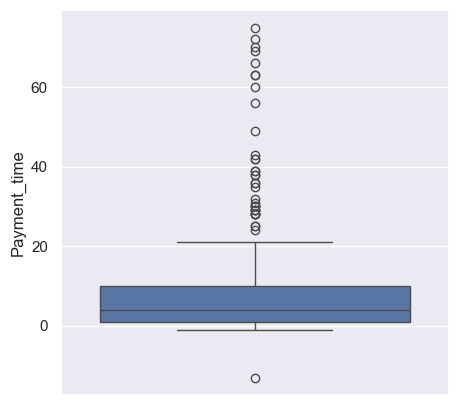

In [13]:
sns.set_theme(rc={'figure.figsize': (5,5)}) # распределение целевой переменной
sns.boxplot(df['Payment_time'])
plt.show()

На представленном Boxplot видно очень большое количество выбросов по целевому признаку, поэтому применяем фильтр для лучшего обучения модели.

In [14]:
# Фильтрация выбросов
df_clean = df[(df['Payment_time'] >= 0) & (df['Payment_time'] <=20)].copy()

In [15]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243 entries, 1 to 283
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Customer      243 non-null    object 
 1   Department    243 non-null    object 
 2   Sum           243 non-null    float64
 3   Responsible   243 non-null    object 
 4   Payment_time  243 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 11.4+ KB


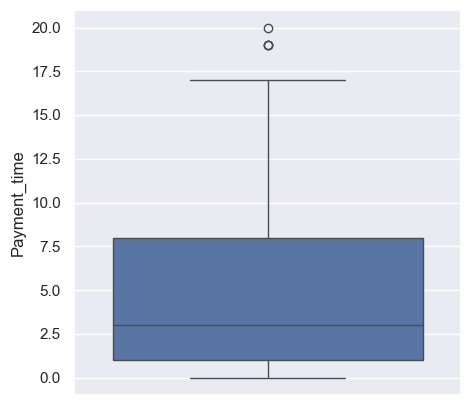

In [16]:
sns.set_theme(rc={'figure.figsize': (5,5)}) # ещё раз смотрим распределение целевой переменной
sns.boxplot(df_clean['Payment_time'])
plt.show()

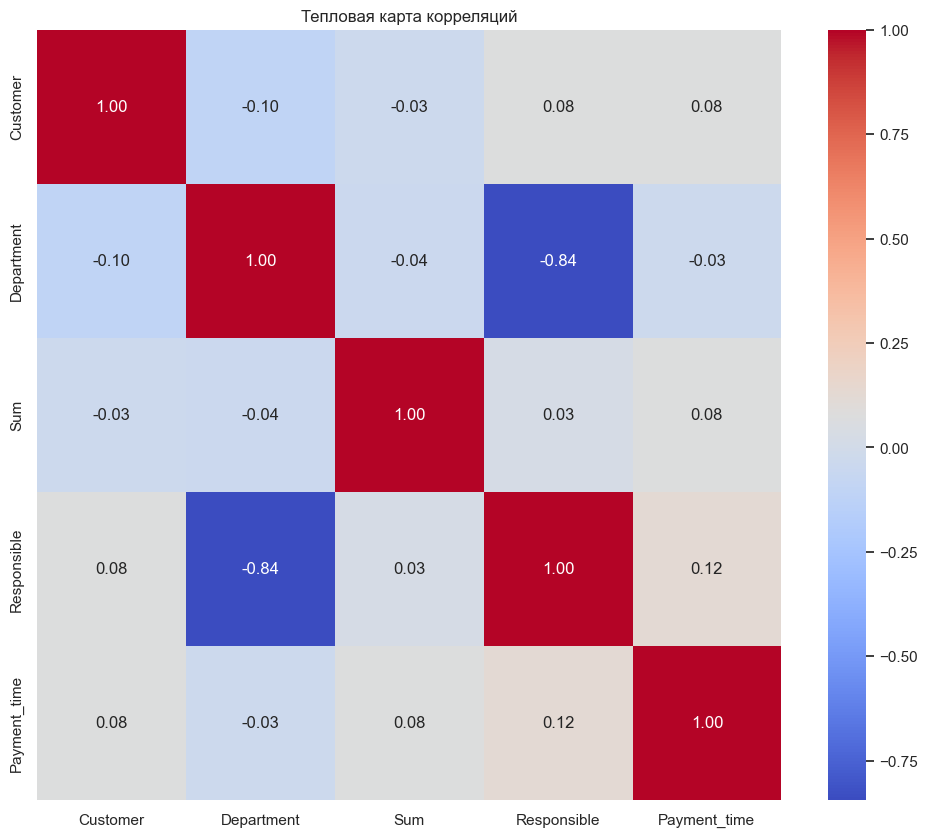

In [17]:
# Создаем копию DataFrame
df_encoded = df_clean.copy()

# Применяем LabelEncoder к категориальным столбцам
for column in ['Customer', 'Department', 'Responsible']:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])

# Строим корреляционную матрицу
plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляций')
plt.show()

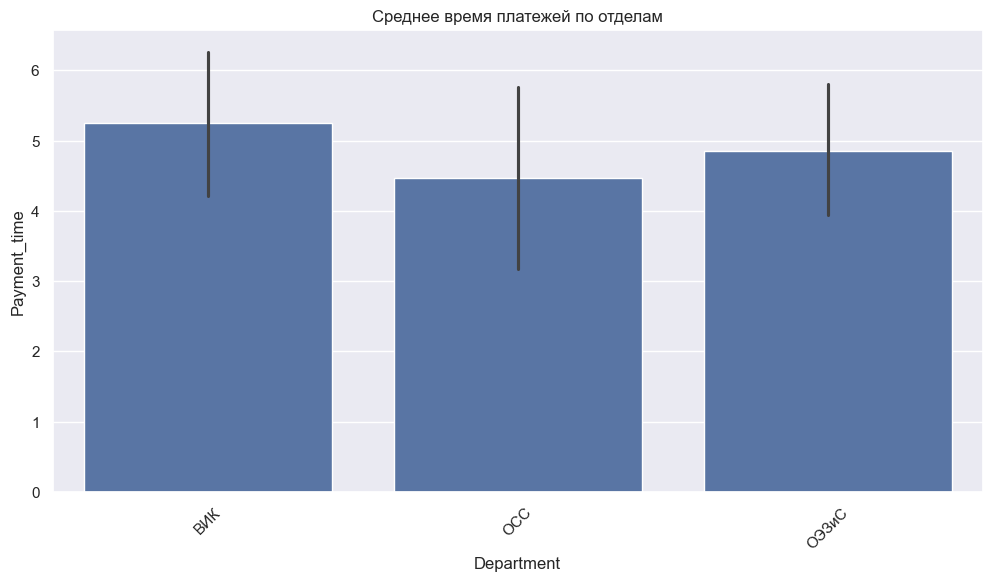

In [18]:
# Смотрим среднее время платежей по отделам на очищенном DF
plt.figure(figsize=(12, 6))
sns.barplot(data=df_clean, x="Department", y="Payment_time", estimator=np.mean)
plt.title("Среднее время платежей по отделам")
plt.xticks(rotation=45)
plt.show()

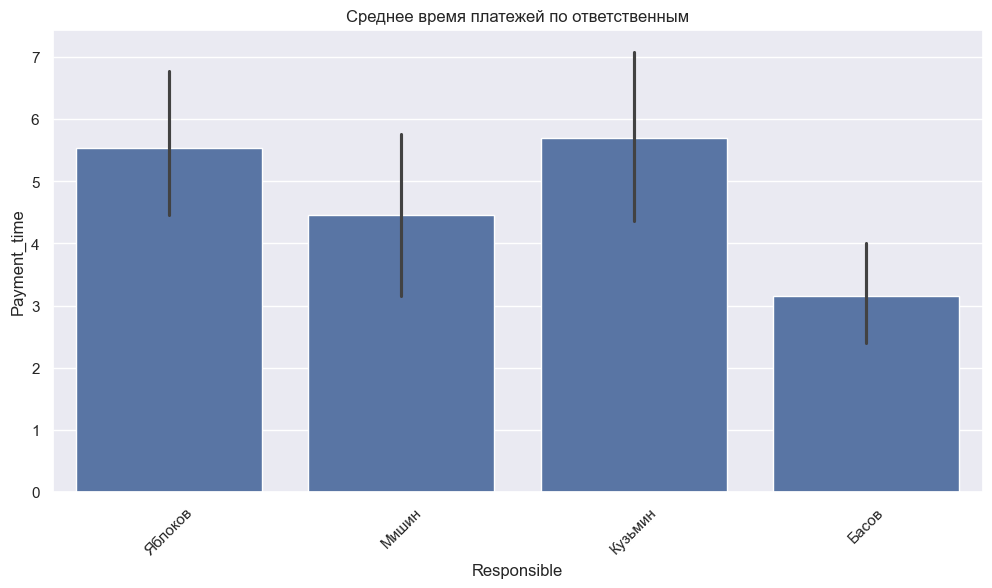

In [19]:
#  Смотрим среднее время платежей по ответственным на очищенном DF
plt.figure(figsize=(12, 6))
sns.barplot(data=df_clean, x="Responsible", y="Payment_time", estimator=np.mean)
plt.title("Среднее время платежей по ответственным")
plt.xticks(rotation=45)
plt.show()

In [20]:
# Создание целевой переменной
df_clean['Payment_delay'] = (df_clean['Payment_time'] > 7).astype(int)

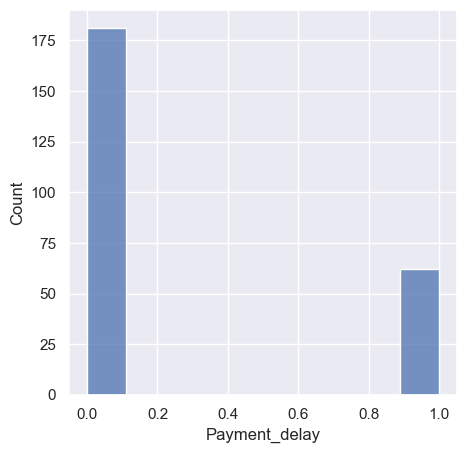

In [21]:
# Смотрим балансировку классов целевой переменной
sns.histplot(df_clean['Payment_delay'])
plt.show()

In [22]:

# Выбор признаков
X = df_clean[['Sum', 'Responsible', 'Customer']]  # Категориальные + числовые
y = df_clean['Payment_delay']

# Кодирование категориальных признаков
X_encoded = pd.get_dummies(X, columns=['Responsible', 'Customer'])



# Разделение данных 
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  
)


# Обучение модели XGBoost
model = XGBClassifier(
    n_estimators=100,
    max_depth=2, # 3
    reg_alpha=1, #
    reg_lambda=1, #
    learning_rate=0.05,
    random_state=42,
    
)

model.fit(X_train, y_train)


y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Вывод результатов
print(f'train accuracy {accuracy_score(y_train, y_pred_train):.3f}')
print(f'test accuracy {accuracy_score(y_test, y_pred_test):.3f}')

train accuracy 0.812
test accuracy 0.740


In [23]:
# Проверка на кросс-валидацию 
scores = cross_val_score(model, X_encoded, y, cv=10)
print(f"Cross-validated accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

Cross-validated accuracy: 0.754 ± 0.058


In [25]:
#Отчёт о результатах
report = classification_report(y_test, y_pred_test)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.94      0.84        54
           1       0.50      0.16      0.24        19

    accuracy                           0.74        73
   macro avg       0.63      0.55      0.54        73
weighted avg       0.69      0.74      0.69        73

